In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/ID_card_thesis/midv_2020.zip

Archive:  gdrive/My Drive/ID_card_thesis/midv_2020.zip
   creating: tmask/
   creating: tmask/photo/
   creating: tmask/photo/annotations/
  inflating: tmask/photo/annotations/alb_id.json  
  inflating: tmask/photo/annotations/esp_id.json  
   creating: tmask/photo/images/
   creating: tmask/photo/images/alb_id/
  inflating: tmask/photo/images/alb_id/00.jpg  
  inflating: tmask/photo/images/alb_id/01.jpg  
  inflating: tmask/photo/images/alb_id/02.jpg  
  inflating: tmask/photo/images/alb_id/03.jpg  
  inflating: tmask/photo/images/alb_id/04.jpg  
  inflating: tmask/photo/images/alb_id/05.jpg  
  inflating: tmask/photo/images/alb_id/06.jpg  
  inflating: tmask/photo/images/alb_id/07.jpg  
  inflating: tmask/photo/images/alb_id/08.jpg  
  inflating: tmask/photo/images/alb_id/09.jpg  
  inflating: tmask/photo/images/alb_id/10.jpg  
  inflating: tmask/photo/images/alb_id/11.jpg  
  inflating: tmask/photo/images/alb_id/12.jpg  
  inflating: tmask/photo/images/alb_id/13.jpg  
  inflating: t

In [ ]:
import json

# reads the json file with the annotations of id cards
def readAnnotationsFile(jsonFile):
  try:
      with open(jsonFile, "r") as read_file:
        data = json.load(read_file)
        return data
  except FileNotFoundError:
    print(f"No such file or directory exists: '{jsonFile}'")
    return None

# retrieves the image name, and the coordinates of id card position in the image
def retrieveImageAttributes(jsonFile):
    
    # data contains the json data read from the json file
    data = readAnnotationsFile(jsonFile)
    
    if(data):
        imageAttributesList = []                            # list to contain attributes of all images in the json file
        imageMetadata = data["_via_img_metadata"]           # metadata of image in which the coordinates are present  
        imageIdList = data["_via_image_id_list"]            # names of images in the metadata

        for img in imageIdList:

            fileName = imageMetadata[img]['filename']                          # filename to which the ground truth image wil be stored
            regions = imageMetadata[img]['regions']
            all_points_x = regions[1]['shape_attributes']['all_points_x']      # all x coordinates  
            all_points_y = regions[1]['shape_attributes']['all_points_y']      # all y coordinates
            imageAttributesList.append((fileName,all_points_x,all_points_y))   

        return imageAttributesList                                             # list of tuples containing (filename, x coordinates and y coordinates) for every image
    else:
        return None

In [ ]:
import numpy as np
from skimage.draw import polygon
import cv2 as cv

# creates groud truth mask from all_points_x and all_points_y of four cornres of ID card in the image
def groundTruth(y_len, x_len, row_arr, col_arr, writeFileName):
    img = np.zeros((y_len, x_len), dtype=np.uint8)
    r = np.array(row_arr)
    c = np.array(col_arr)
    rr, cc = polygon(r,c)
    img[rr,cc] = 255
    
    cv.imwrite(writeFileName, img)

In [ ]:
import os 

# creates a new directory 
def createDirectory(filePath, newDirectory):
    path = os.path.join(filePath, newDirectory)
    os.mkdir(path)
    
    return path
# creates ground truth mask at the specified path given
def createMask(filePath, fileName, imgHeight, imgWidth, all_points_y, all_points_x):

    writeFilePath = os.path.join(filePath, fileName)
    groundTruth(imgHeight, imgWidth, all_points_y, all_points_x, writeFilePath)

In [ ]:
PHOTO_HEIGHT = 4032                     # height of images in photos folder
PHOTO_WIDTH = 2268                      # width of images in photos folder

SCAN_HEIGHT = 3507                      # height of images in scanned_rotated and scanned_upright folder
SCAN_WIDTH = 2480                       # width of images in  scanned_rotated and scanned_upright folder

PATH_PREFIX = 'tmask'                   # name of the folder containing the dataset

pathSuffix = ["annotations/alb_id.json", "annotations/esp_id.json"]
idClass = ["alb_id", "esp_id"]



typePath = ["photo", "scan_rotated", "scan_upright"]

# creates ground truth mask for Albanian and Spanish ID cards in the entire dataset
for fol in typePath:
    maskDir = createDirectory(os.path.join(PATH_PREFIX, fol), "mask")
    for i in range(len(pathSuffix)):
        imageAttributeList = retrieveImageAttributes(os.path.join(PATH_PREFIX, fol, pathSuffix[i]))
        idPath = createDirectory(maskDir, idClass[i])

        if imageAttributeList:
          for img in imageAttributeList:
              if(fol == "photo"):
                  createMask(idPath, img[0], PHOTO_HEIGHT, PHOTO_WIDTH, img[2], img[1])
              else:
                  createMask(idPath, img[0], SCAN_HEIGHT, SCAN_WIDTH, img[2], img[1])
        else:
          print('empty')

# approx 4 minute running time

In [ ]:
import shutil

src_path = "tmask"
dst_path = "dataset"
destination = shutil.copytree(src_path, dst_path) 


In [ ]:
TEMP_PATH_PREFIX = "dataset"
IMG_PATH_SUFFIX = ["images", "mask"]

In [ ]:
imageNumbering = [0, 100, 200, 300, 400 ,500]

FINAL_DATA_FOLDER = "data"
FINAL_IMG_PATH = os.path.join(FINAL_DATA_FOLDER, IMG_PATH_SUFFIX[0])
FINAL_MASK_PATH = os.path.join(FINAL_DATA_FOLDER, IMG_PATH_SUFFIX[1])
os.mkdir(FINAL_DATA_FOLDER)
os.mkdir(FINAL_IMG_PATH)
os.mkdir(FINAL_MASK_PATH)

imgNum = 0
for path in typePath:
  imgPath = FINAL_IMG_PATH
  for fol in IMG_PATH_SUFFIX:
    for cls in idClass:
      idPath = os.path.join(TEMP_PATH_PREFIX,path,fol,cls)
      if(len(os.listdir(idPath))==100):
        if(cls == "alb_id"):
          tmp_ = imgNum
        else:
          tmp_ = imgNum + 3
        for i in range(0,100):
          fileName = f"{i:02}"+str(".jpg")
          newName = f"{(imageNumbering[tmp_]+i):02}"+str(".jpg")
          os.rename(os.path.join(idPath,fileName),os.path.join(imgPath,newName))
      else:
        print("Files not read proerly")
    imgPath = FINAL_MASK_PATH
  imgNum += 1
  break


In [ ]:
shutil.rmtree("dataset")

In [ ]:
import os
imageNames = os.listdir("data/images")
maskNames = os.listdir("data/mask")

In [ ]:
imageNames.sort()

In [ ]:
maskNames.sort()

In [ ]:
for i in range(1,200):
  if(imageNames[i] != maskNames[i]):
    print(imageNames[i])
    print(maskNames[i])
    print("------------------------")
  

In [ ]:
print(imageNames[81])
print(maskNames[81])

346.jpg
346.jpg


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imageNames, maskNames, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(len(X_train), len(y_train))

120 120


In [ ]:
print(len(X_val), len(y_val))

40 40


In [ ]:
print(len(X_test), len(y_test))

40 40


In [ ]:
X_train[0]

'310.jpg'

In [ ]:
X_val[0]

'303.jpg'

In [ ]:
256*2

512

In [ ]:
def read_images(image_list):
  temp_image_list = []
  for image in image_list:
    orig_img = cv.imread(os.path.join("data/images",image))
    res_img = cv.resize(orig_img, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_image_list.append(tf.constant(res_img))
  return temp_image_list

def read_masks(mask_list):
  temp_mask_list = []
  for mask in mask_list:
    orig_msk = cv.imread(os.path.join("data/mask",mask),cv.IMREAD_GRAYSCALE)
    res_msk = cv.resize(orig_msk, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_mask_list.append(tf.constant(np.expand_dims(res_msk,axis=2)))
  return temp_mask_list

In [ ]:
train_images = read_images(X_train)
train_masks = read_masks(y_train)
val_images = read_images(X_val)
val_masks = read_masks(y_val)
test_images = read_images(X_test)
test_masks = read_masks(y_test)

# approx 1m 40s

In [ ]:
len(train_images)

120

In [ ]:
len(train_masks)

120

In [ ]:
len(val_images)

40

In [ ]:
len(val_masks)

40

In [ ]:
len(test_images)

40

In [ ]:
len(test_masks)

40

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In [ ]:
BATCH_SIZE = 16
train_batches = train_dataset.batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_batches = val_dataset.batch(BATCH_SIZE).repeat()
val_batches = val_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_batches = test_dataset.batch(BATCH_SIZE).repeat()
test_batches = test_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

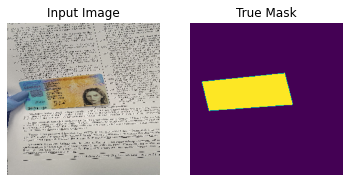

In [ ]:
def display(display_list):
 plt.figure()

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
  # inputs
  inputs = layers.Input(shape=(256,256,3))

  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)

  bottleneck = double_conv_block(p3, 512)

  u6 = upsample_block(bottleneck, f3, 256)
  u7 = upsample_block(u6, f2, 128)
  u8 = upsample_block(u7, f1, 64)

  outputs = layers.Conv2D(1, 1, padding="same",activation='sigmoid')(u8)

  # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_59[0][0]']              
                                )                                                             

In [ ]:
len(train_dataset)

120

In [ ]:
def MyCallback():
  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer]
  return callbacks


In [ ]:
NUM_EPOCHS = 60

TRAIN_LENGTH = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# VAL_SUBSPLITS = 5
TEST_LENTH = len(val_dataset)
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE 

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_batches,
                               callbacks=[MyCallback()])

Epoch 1/60
7/7 [==============================] - 5s 490ms/step - loss: 0.9793 - accuracy: 0.8321 - val_loss: 0.4984 - val_accuracy: 0.8591
Epoch 2/60
7/7 [==============================] - 3s 455ms/step - loss: 0.4311 - accuracy: 0.8715 - val_loss: 0.4084 - val_accuracy: 0.8624
Epoch 3/60
7/7 [==============================] - 3s 410ms/step - loss: 0.3931 - accuracy: 0.8812 - val_loss: 0.4102 - val_accuracy: 0.8680
Epoch 4/60
7/7 [==============================] - 3s 428ms/step - loss: 0.3739 - accuracy: 0.8904 - val_loss: 0.3783 - val_accuracy: 0.8817
Epoch 5/60
7/7 [==============================] - 3s 423ms/step - loss: 0.3612 - accuracy: 0.8971 - val_loss: 0.3417 - val_accuracy: 0.8803
Epoch 6/60
7/7 [==============================] - 3s 429ms/step - loss: 0.3408 - accuracy: 0.8960 - val_loss: 0.3274 - val_accuracy: 0.8795
Epoch 7/60
7/7 [==============================] - 3s 428ms/step - loss: 0.3272 - accuracy: 0.8963 - val_loss: 0.3105 - val_accuracy: 0.8885
Epoch 8/60
7/7 [====

In [ ]:
temp_test = next(iter(test_dataset))

In [ ]:
PREDICT_LENGTH = len(test_dataset)
PREDICTION_STEPS = PREDICT_LENGTH // BATCH_SIZE

In [ ]:
pred = unet_model.predict(x=test_batches,
                          steps=PREDICTION_STEPS, verbose=0)

In [ ]:
pred.shape

(32, 256, 256, 1)

In [ ]:
pred[0].shape

(256, 256, 1)

In [ ]:
import matplotlib
from google.colab import files

def pred_masks(predictions, test_batch):
  for batch in test_batch:
    first_batch = batch
    break
  true_images = first_batch[0]
  true_masks = first_batch[1]

  curr_iter = 0
  max_imgs = 30
  all_images = []
  res_path = createDirectory('/content/','prediction')
  for true_img, true_msk, pred_msk in zip(true_images, true_masks, predictions):
    comparison = []
    img = np.squeeze(true_img).copy()*255
    msk = np.squeeze(true_msk).copy()*255
    msk = np.stack((msk,)*3, axis=-1)
    res = pred_msk.copy()
    res = res[:,:,0]
    res[res >= 0.9] = 255
    res[res < 0.9] = 0
    res = np.stack((res,)*3, axis=-1)
    comparison = np.concatenate((img,msk,res), axis=1)
    cv2_imshow(comparison)

    temp_comparison = comparison.copy()
    temp_comparison = temp_comparison.astype(int)
    temp_comparison = np.uint8(temp_comparison)

    img_write = os.path.join(res_path,f'{curr_iter}.png')
    matplotlib.image.imsave(img_write, temp_comparison)
    files.download(img_write)
    curr_iter += 1
    if curr_iter == 30:
      break

In [ ]:
for i in test_batches:
  print(np.histogram(i[1][0]))
  break

(array([62802,     0,     0,     0,     0,     0,     0,     0,     0,
        2734]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [ ]:
for i in pred:
  print(np.histogram(i))
  break

(array([58919,  1806,   714,   363,   357,   318,   326,   277,   251,
        2205]), array([1.3990412e-33, 9.9999830e-02, 1.9999966e-01, 2.9999951e-01,
       3.9999932e-01, 4.9999917e-01, 5.9999901e-01, 6.9999886e-01,
       7.9999864e-01, 8.9999849e-01, 9.9999833e-01], dtype=float32))


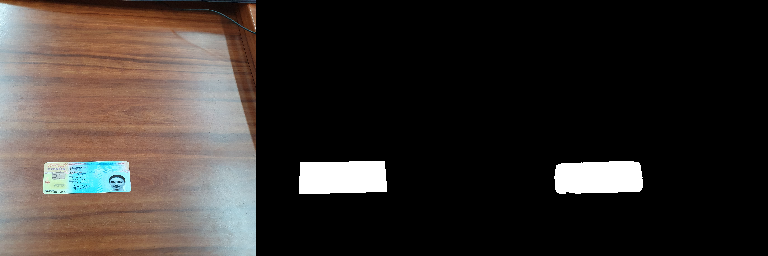

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

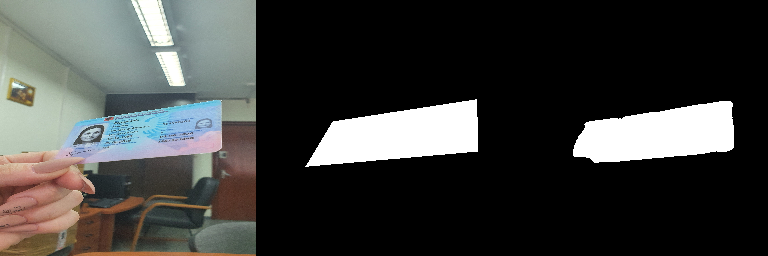

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

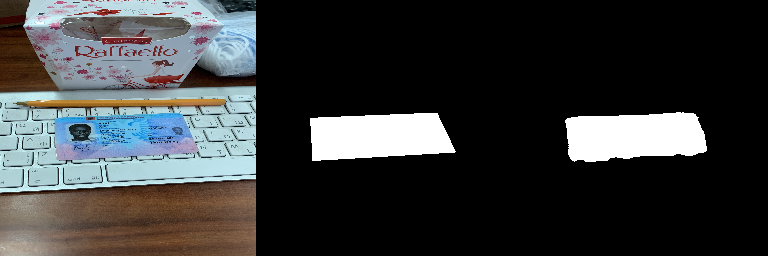

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

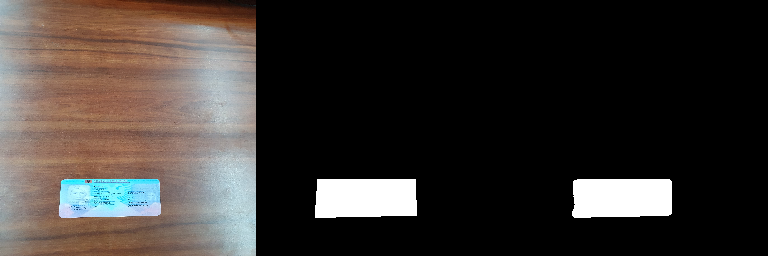

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

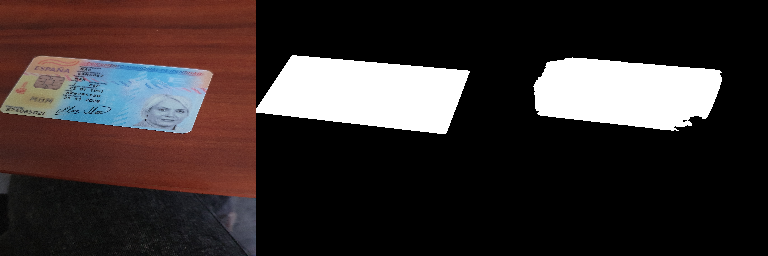

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

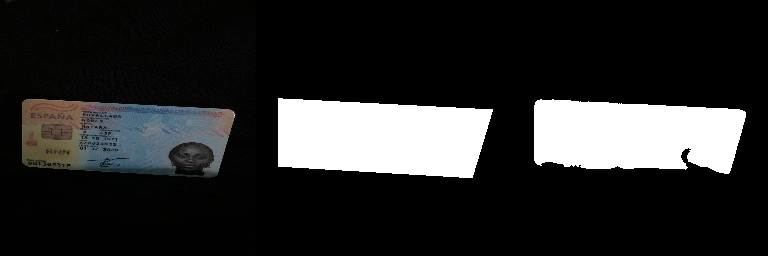

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

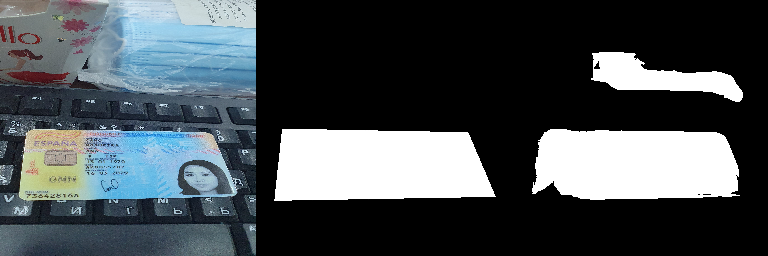

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

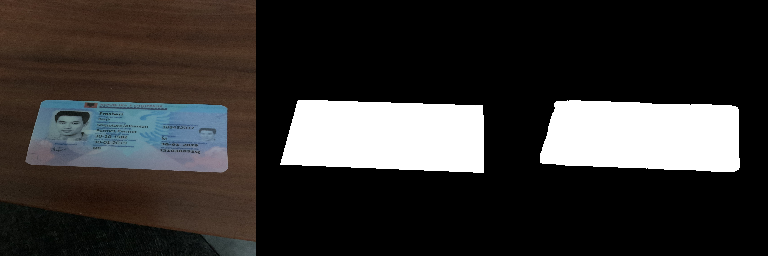

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

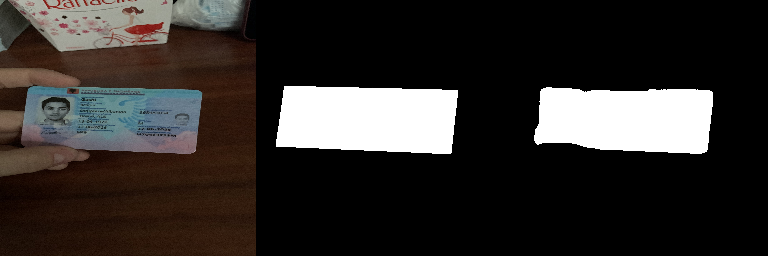

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

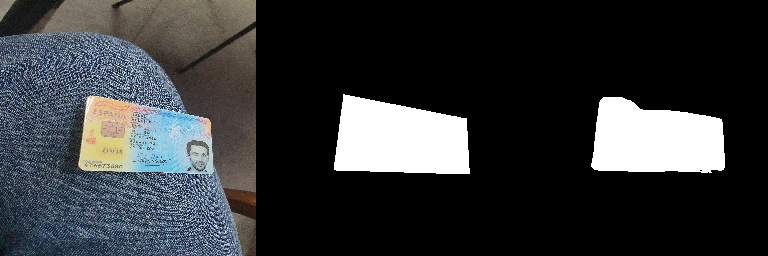

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

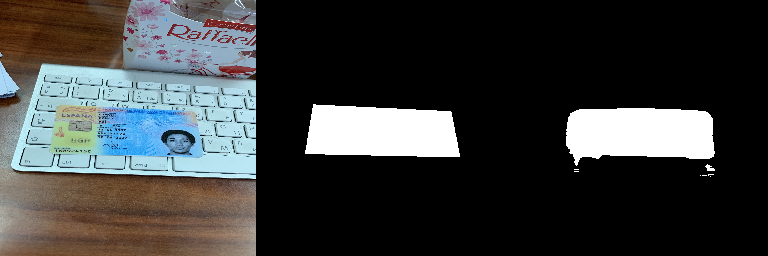

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

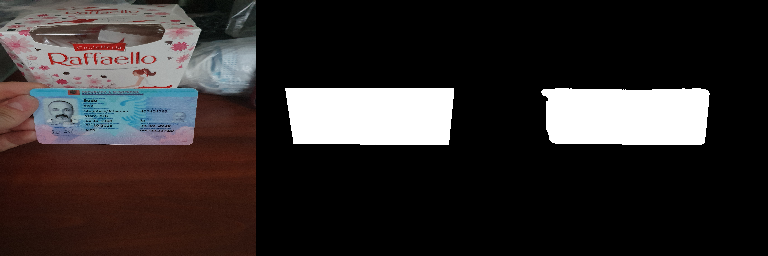

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

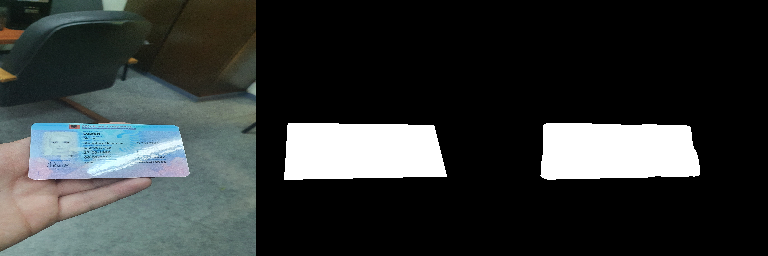

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

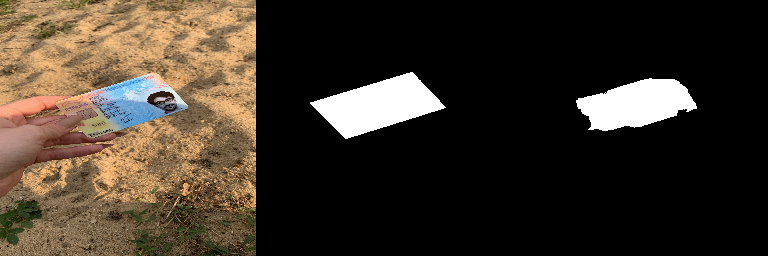

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

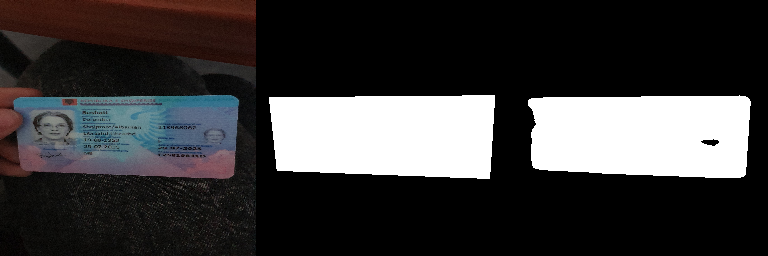

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

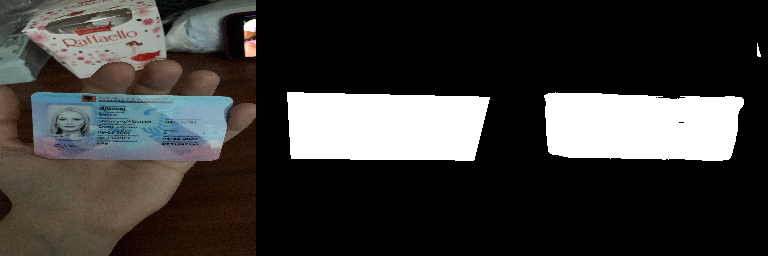

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred_masks(pred, test_batches)